# librairie

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc

from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency


from sklearn.svm import SVC


# Fonctions

In [10]:
def IV_WoE_Coarse(df,var,label,tar, pr=False):
    
    lst = []
    df[var] = df[var].fillna("NULL")

    for i in range(df[var].nunique()):
        val = list(df[var].unique())[i]
        val_1 = list(df[label].unique())[i]
        lst.append([val,                                                 # Variable
                    val_1,                                                 # Modalité
                    df[df[var] == val].count()[var],                     # Total
                    df[(df[var] == val) & (tar == 0)].count()[var],  # Good
                    df[(df[var] == val) & (tar == 1)].count()[var]]) # Bad
    
    data = pd.DataFrame(lst, columns=['Groupes', 'Labels', 'Total', 'Not Converted', 'Converted'])

    data['Share'] = data['Total'] / data['Total'].sum()
    data['Converted Rate'] = data['Converted'] / data['Total']
    data['Distribution Not Converted'] = (data['Total'] - data['Converted']) / (data['Total'].sum() - data['Converted'].sum())
    data['Distribution Converted'] = data['Converted'] / data['Converted'].sum()
    data['WoE'] = np.log(data['Distribution Converted'] / data['Distribution Not Converted'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Converted'] - data['Distribution Not Converted'])
    data['sum'] = data['IV'].sum()

    data = data.sort_values(by=['Groupes', 'Labels'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())


    iv = data['IV'].sum()
    # print(iv)

    return iv, data

# IMPORT DE LA BASE

In [11]:
df = pd.read_csv("train_set.csv")
y_train = df.label

df.drop_duplicates(subset='id',keep='first',inplace=True)
if (df.isnull().values.any()):
    print("check for NaN in dataset")

# regle d'elimination : + 80% de corrélation en valeur absolu entre deux variables 
def drop_base(df):
    df.drop(['id','dloss','dpkts','dmean','swin','ct_flw_http_mthd',
            'stcpb','ct_ftp_cmd','sbytes','ct_srv_dst','dtcpb','label',
             'sloss','dwin','dbytes','ct_dst_sport_ltm','ct_srv_src','ct_dst_src_ltm'],axis=1,inplace=True)
    df.drop(['rate','synack','tcprtt','sjit','djit','sinpkt','dinpkt','sload'],axis=1,inplace=True)
    df.drop(['attack_cat','response_body_len','is_ftp_login'],axis=1,inplace=True)
    return df
df = drop_base(df)

var_quanti = df.dtypes[df.dtypes=='float64'].index.tolist()
var_int = df.dtypes[df.dtypes=='int64'].index.tolist()
var_objet = df.dtypes[df.dtypes=="objet"].index.tolist()

## float

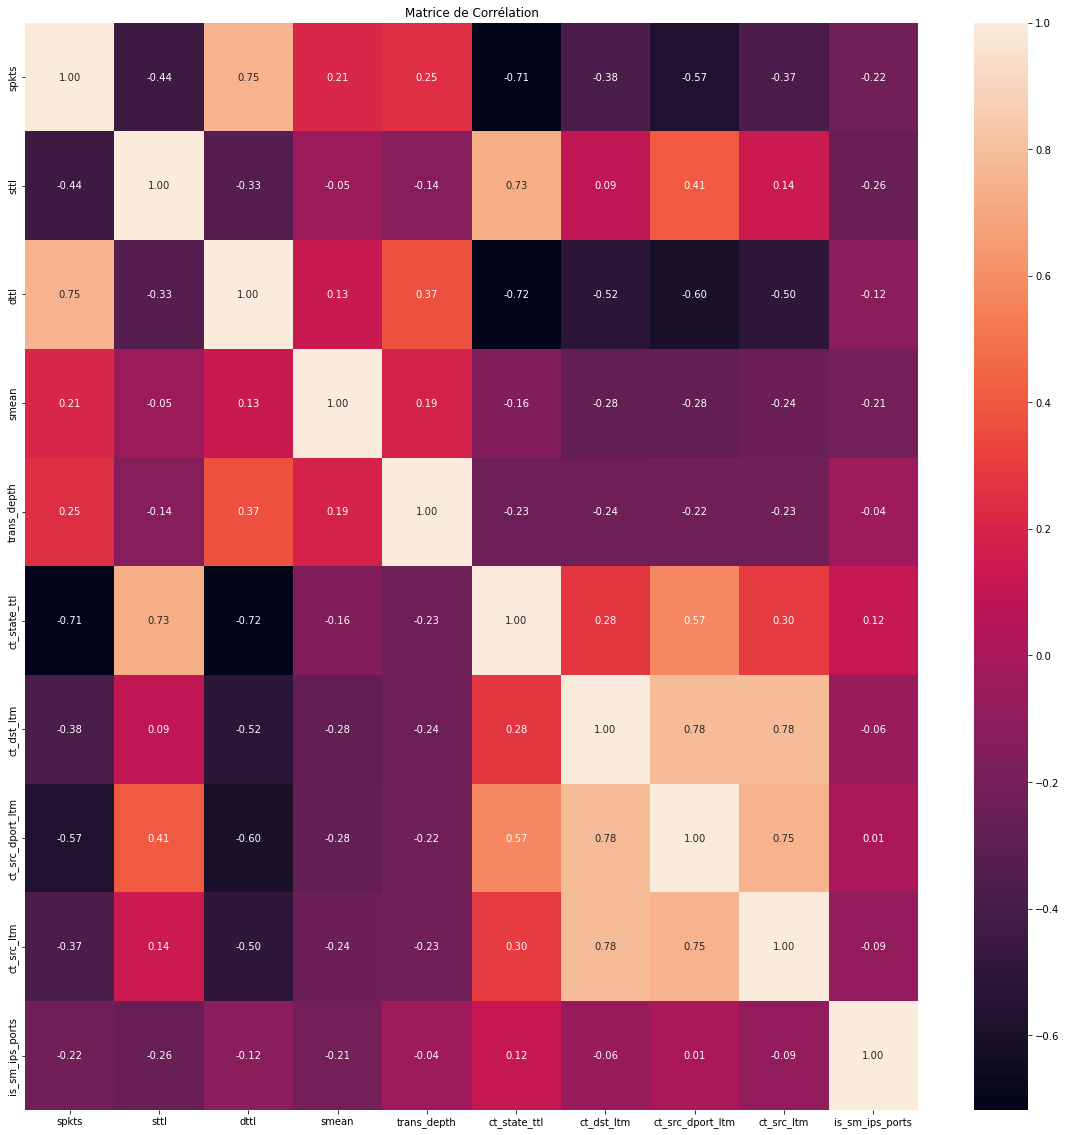

In [ ]:
correlation = df[var_int].corr(method='spearman',min_periods = 100) # Spearman méthod car variables catégorielles
plt.figure(figsize=(20,20))
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot=True, fmt='.2f')
plt.title('Matrice de Corrélation')
plt.show()

## Intégrale

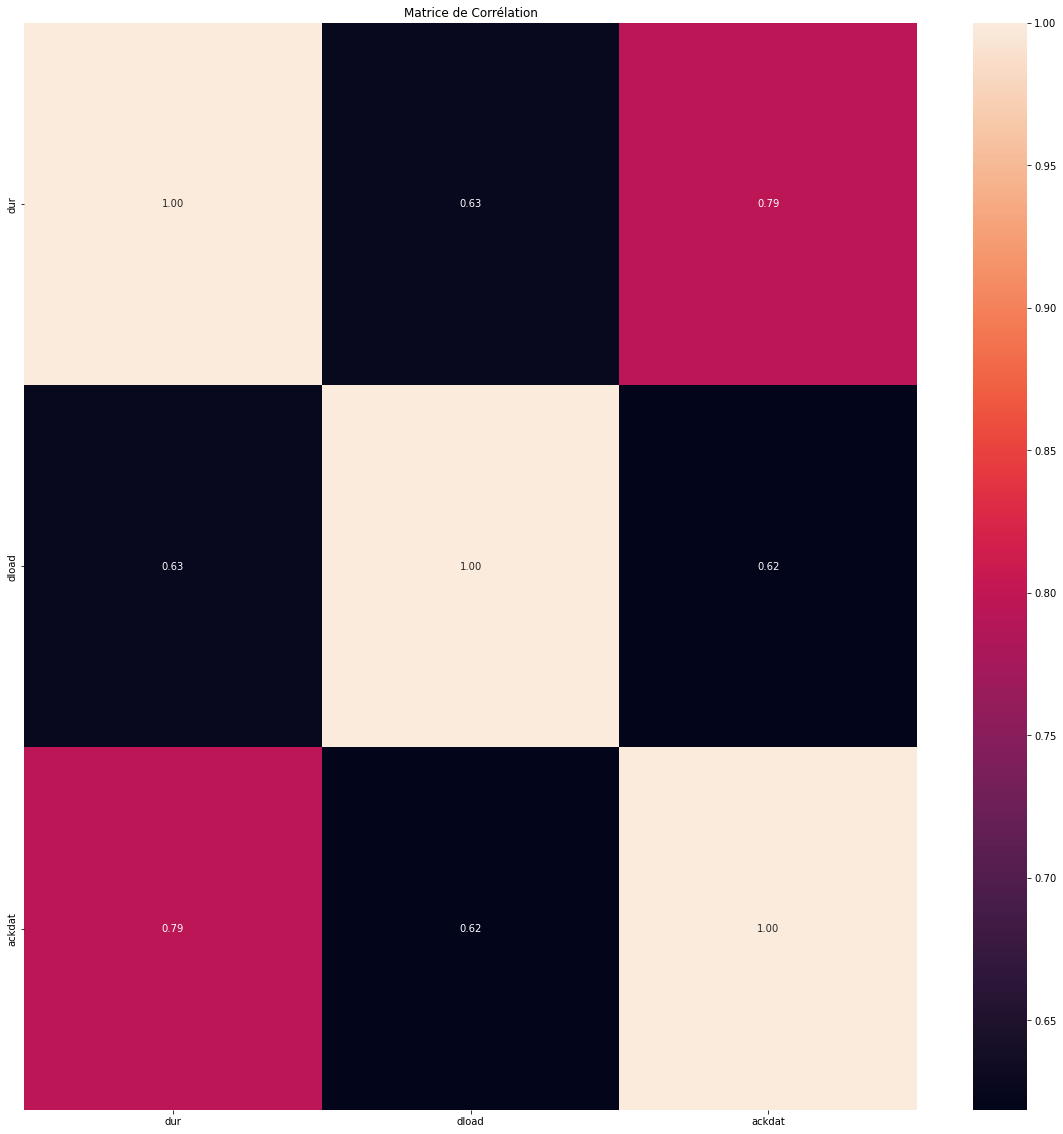

In [ ]:
correlation = df[var_quanti].corr(method='spearman',min_periods = 100) # Spearman méthod car variables catégorielles
plt.figure(figsize=(20,20))
sns.heatmap(correlation, 
            xticklabels=correlation.columns.values,
            yticklabels=correlation.columns.values, annot=True, fmt='.2f')
plt.title('Matrice de Corrélation')
plt.show()

In [ ]:
df_cat = df.select_dtypes(include = 'object').copy()
df_num = df.select_dtypes(include = 'number').copy()

# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(df_num, y_train)

# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': df_num.columns.values,
					'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})

ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,sttl,161780.526952,0.000000
1,ct_state_ttl,87830.779493,0.000000
2,dload,32170.312851,0.000000
3,ct_src_dport_ltm,18059.210546,0.000000
4,ct_src_ltm,10549.386809,0.000000
5,ct_dst_ltm,9783.377995,0.000000
6,is_sm_ips_ports,6191.368613,0.000000
7,ackdat,1678.075241,0.000000
8,dttl,1598.495322,0.000000
9,spkts,478.672832,0.000000


## objet

In [ ]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in df_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, df_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,proto,0.0
1,service,0.0
2,state,0.0


In [ ]:
def create_label(df):

    df['state : CON']=np.where((df.state=='CON'),1,0)
    df['state : FIN']=np.where((df.state=='FIN'),1,0)
    df['state : INT']=np.where((df.state=='INT'),1,0)
    df['state : REQ']=np.where((df.state=='REQ'),1,0)

    df['service : dns']=np.where((df.service=='dns'),1,0)
    df['service : http']=np.where((df.service=='http'),1,0)
    df['service : smtp']=np.where((df.service=='smtp'),1,0)
    df['service : ftp']=np.where((df.service=='ftp'),1,0)
    df['service : pop3']=np.where((df.service=='pop3'),1,0)
    df['service : ssh']=np.where((df.service=='ssh'),1,0)
    df['service : NA']=np.where((df.service=='-'),1,0)
    
    df = df.drop(['state','service','proto'],axis=1)
    return df
liste_objet_dummy = ['state : CON','state : FIN','state : INT','state : REQ',
                    'service : dns','service : http','service : smtp','service : ftp',
                    'service : pop3','service : ssh','service : NA']
df= create_label(df)

In [ ]:
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(df[liste_objet_dummy], y_train)

# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': df[liste_objet_dummy].columns.values,
					'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})

ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,state : INT,59703.328125,0.000000
1,state : CON,27258.671875,0.000000
2,state : FIN,17765.078125,0.000000
3,service : dns,8072.299316,0.000000
4,service : NA,4483.979492,0.000000
5,service : ssh,2769.500732,0.000000
6,service : pop3,511.523285,0.000000
7,state : REQ,195.573593,0.000000
8,service : http,109.945488,0.000000
9,service : ftp,20.768642,0.000005


In [ ]:
def corriger_df(df):
    df = df.drop(['service : smtp'],axis=1)
    return df
df = corriger_df(df)

In [17]:
for col in list(df.columns):
    if col != 'label':
        cross = pd.crosstab(df[col], df['label'])
        print(cross, "\n")


label   0  1
id          
1       1  0
2       1  0
3       1  0
4       1  0
5       1  0
...    .. ..
175337  0  1
175338  0  1
175339  0  1
175340  0  1
175341  0  1

[175341 rows x 2 columns] 

label         0      1
dur                   
0.000000   2630     27
0.000001    145   3059
0.000002    124   2261
0.000003    333  11418
0.000004    288   4738
...         ...    ...
59.999943     2      0
59.999947     2      0
59.999966     2      0
59.999985     2      0
59.999989     4      0

[74039 rows x 2 columns] 

label      0    1
proto            
3pc        0  100
a/n        0  100
aes-sp3-d  0  100
any        0  300
argus      0   98
...       ..  ...
wsn        0  100
xnet       0   99
xns-idp    0   99
xtp        0  100
zero       0  100

[133 rows x 2 columns] 

label         0      1
service               
-         36512  57656
dhcp          0     94
dns        7493  39801
ftp        1218   2210
ftp-data   2552   1443
http       5348  13376
irc           0     25
pop3    

## Transformer les variables continues en groupe

In [ ]:
var_quanti = df.dtypes[df.dtypes=='float64'].index.tolist()
var_int = df.dtypes[df.dtypes=='int64'].index.tolist()
var_continue = var_int + var_quanti

var_continue.remove('is_sm_ips_ports') #car binaire et valider par ANOVA

In [ ]:
IV1 = {}
X_train=df
for i in var_continue:
    name = 'q'+i
    X_train[name]=pd.qcut(X_train[i],10,precision=0,labels=False,duplicates='drop')
    name_bis = 'labels'+i
    X_train[name_bis]=pd.qcut(X_train[i],10,precision=0,duplicates='drop')
    IV1[i]=IV_WoE_Coarse(X_train,name,name_bis,y_train,pr=True)[1]

   Groupes          Labels  Total  Not Converted  Converted     Share  \
0        0      (0.0, 2.0]  88146          13644      74502  0.502712   
1        1     (2.0, 10.0]  37157          13547      23610  0.211913   
2        2    (10.0, 16.0]  15574           8022       7552  0.088821   
3        3    (16.0, 48.0]  18687           9434       9253  0.106575   
4        4  (48.0, 9616.0]  15777          11353       4424  0.089979   

   Converted Rate  Distribution Not Converted  Distribution Converted  \
0        0.845211                    0.243643                0.624278   
1        0.635412                    0.241911                0.197836   
2        0.484911                    0.143250                0.063281   
3        0.495157                    0.168464                0.077534   
4        0.280408                    0.202732                0.037070   

        WoE        IV       sum  
0  0.940893  0.358137  0.784371  
1 -0.201128  0.008865  0.784371  
2 -0.817009  0.06533

C:\Users\schut\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


   Groupes          Labels   Total  Not Converted  Converted     Share  \
0        0    (-1.0, 29.0]  123827          46201      77626  0.706207   
1        1   (29.0, 252.0]   51512           9797      41715  0.293782   
2        2  (252.0, 254.0]       2              2          0  0.000011   

   Converted Rate  Distribution Not Converted  Distribution Converted  \
0        0.626891                    0.825018                0.650455   
1        0.809811                    0.174946                0.349545   
2        0.000000                    0.000036                0.000000   

        WoE        IV       sum  
0 -0.237732  0.041499  0.162347  
1  0.692151  0.120848  0.162347  
2  0.000000 -0.000000  0.162347  
IV =  0.16234746588472337
   Groupes           Labels  Total  Not Converted  Converted     Share  \
0        0     (27.0, 53.0]  18532           9027       9505  0.105691   
1        1     (53.0, 57.0]  47954           2758      45196  0.273490   
2        2     (57.0, 59.0

   Groupes                  Labels  Total  Not Converted  Converted     Share  \
0        0          (-1.0, 1447.0]  87671           7957      79714  0.500003   
1        1        (1447.0, 3839.0]  17534           4741      12793  0.099999   
2        2        (3839.0, 9362.0]  17534           4043      13491  0.099999   
3        3       (9362.0, 91399.0]  17534           8091       9443  0.099999   
4        4     (91399.0, 793106.0]  17534          14299       3235  0.099999   
5        5  (793106.0, 22422730.0]  17534          16869        665  0.099999   

   Converted Rate  Distribution Not Converted  Distribution Converted  \
0        0.909240                    0.142089                0.667952   
1        0.729611                    0.084661                0.107197   
2        0.769419                    0.072196                0.113046   
3        0.538554                    0.144482                0.079126   
4        0.184499                    0.255339                0.0271

C:\Users\schut\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
liste_quant = []
for i in var_continue : 
    x = sum(IV1[i]['IV'])
    if x>0.05:
        print(i,x)
        liste_quant.append(i)

spkts 0.7843708917346471
sttl 5.365870176693721
dttl 0.16234746588472337
smean 1.897754762746488
ct_state_ttl 1.521019764765143
ct_dst_ltm 1.0139953686249599
ct_src_dport_ltm 0.9361791548098328
ct_src_ltm 0.8730557172725475
dur 3.183047733800871
dload 2.56847980192718
ackdat 0.11078468864610684


In [ ]:
def transform(df):
    df['spkts : <= 1']=np.where((df['spkts']<=1),1,0)
    df['spkts : <= 3']=np.where((df['spkts']<3) & (df['spkts']>1),1,0)
    df['spkts : > 3']=np.where((df['spkts']>=3),1,0)

    df['sttl : < 1']=np.where((df['sttl']<1),1,0)
    df['sttl : >= 1']=np.where((df['sttl']>=1),1,0)
    
    df['dttl : <= 29']=np.where((df['dttl']<=29),1,0)
    df['dttl : > 29']=np.where((df['dttl']>29),1,0)
    
    df['smean : <=73']=np.where((df['smean']<=73),1,0)
    df['smean : >73']=np.where((df['smean']>73),1,0)

    df['ct_state_ttl : <=1']=np.where((df['ct_state_ttl']<=1),1,0)
    df['ct_state_ttl : <=1']=np.where((df['ct_state_ttl']>1),1,0)

    df['ct_dst_ltm : <=17']=np.where((df['ct_dst_ltm']<=17),1,0)
    df['ct_dst_ltm : >17']=np.where((df['ct_dst_ltm']>17),1,0)
    
    df['ct_src_dport_ltm : <=10']=np.where((df['ct_src_dport_ltm']<=10),1,0)
    df['ct_src_dport_ltm : >10']=np.where((df['ct_src_dport_ltm']>10),1,0)
    
    df['ct_src_ltm : <=14']=np.where((df['ct_src_ltm']<=14),1,0)
    df['ct_src_ltm : >14']=np.where((df['ct_src_ltm']>14),1,0)
    
    df['dur : <=9^-6']=np.where((df['dur']<=9e-06),1,0)
    df['dur : >9^-6']=np.where((df['dur']>9e-06),1,0)
    
    df['dload : <=1447']=np.where((df['dload']<=1447),1,0)
    df['dload : <=91399']=np.where((df['dload']<=91399) & (df.dload>1447),1,0)
    df['dload : <=22422730']=np.where((df['dload']>91399),1,0)
    
    df['ackdat : <=0.0002']=np.where((df['ackdat']<=0.0002),1,0)
    df['ackdat : >0.0002']=np.where((df['ackdat']>0.0002),1,0)
    
    df = df.drop(['spkts','sttl','dttl','smean','ct_state_ttl','ct_dst_ltm','ct_src_dport_ltm','ct_src_ltm',
            'dur','dload','ackdat','trans_depth'],axis=1)

    return df

In [ ]:
df = transform(df)
df = df.drop(['labelsspkts','labelssttl','labelsdttl','labelssmean','labelsct_state_ttl','labelsct_dst_ltm',
            'labelsct_src_dport_ltm','labelsct_src_ltm','labelsdur','labelsdload','labelsackdat','labelstrans_depth'],axis=1)
df = df.drop(['qspkts','qsttl','qdttl','qsmean','qtrans_depth','qct_state_ttl','qct_dst_ltm',
 'qct_src_dport_ltm','qct_src_ltm','qdur','qdload','qackdat'],axis=1)

In [ ]:
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(df, y_train)

# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': df.columns.values,
					'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})

ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,dload : <=22422730,104257.696665,0.000000
1,state : INT,59703.332860,0.000000
2,dload : <=1447,55502.864520,0.000000
3,ct_state_ttl : <=1,53964.340284,0.000000
4,dur : >9^-6,46565.235017,0.000000
5,dur : <=9^-6,46565.235017,0.000000
6,spkts : <= 3,32709.536768,0.000000
7,state : CON,27258.672011,0.000000
8,spkts : > 3,25273.142090,0.000000
9,ct_src_dport_ltm : <=10,18715.067661,0.000000


In [ ]:
def corriger2(df):
    df.drop(['dload : <=91399'],axis=1,inplace=True)
    return df
df = corriger2(df)

# MODELE 

In [ ]:
reg = LogisticRegression(max_iter=1000,class_weight='balanced')
reg.fit(df,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
df_test = pd.read_csv("test_set.csv")
y_true = df_test.label
df_test = drop_base(df_test)
df_test = create_label(df_test)
df_test = corriger_df(df_test)
df_test = transform(df_test)
df_test = corriger2(df_test)

y_test = reg.predict(df_test)

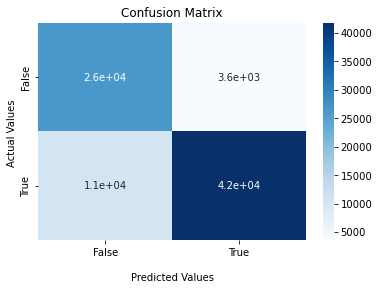

In [ ]:
cf_matrix = confusion_matrix(y_test,y_true)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
T0 = cf_matrix[0][0]/(cf_matrix[0][0]+cf_matrix[0][1])
T1 = cf_matrix[1][1]/(cf_matrix[1][0]+cf_matrix[1][1])
print( " T0 = ",T0," & T1 = ",T1)

 T0 =  0.8817830747719555  & T1 =  0.7989635522239645


0.84037331349796


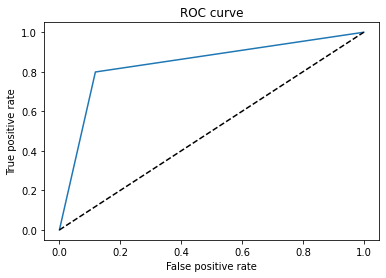

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, 
                                 y_true)
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

print(roc_auc_score(y_test,y_true))

## CONSTRUCTION DE LA SCORE CARD 

In [ ]:
base_final = pd.DataFrame()
ref_categories = list(df_test.columns)
a = pd.DataFrame(reg.coef_).transpose()

check = list(df_test.columns)
base_final['nom'] = ref_categories

base_final['coef'] = a

base_final['size']=0
base_final['att']=0

base_final.set_index('nom')
df_test_bis = df_test
df_test_bis['label']=y_true
for i in check:
    x = sum(df_test_bis[i]==1)
    base_final.loc[base_final.nom==i,'size']=x
    for_run = df_test_bis[df_test_bis[i]==1]
    x = sum(for_run['label'])
    if (x>len(for_run)):
        print('mistake')
    base_final.loc[base_final.nom==i,'att']=x
    
base_final['non_att']=base_final['size']-base_final['att']
df_test.drop(['label'],axis=1,inplace=True)

In [ ]:
min_score = 0
max_score = 100

base_final['Nom initial'] = base_final['nom'].str.split(':').str[0]
min_sum_coef = base_final.groupby('Nom initial')['coef'].min().sum()
max_sum_coef = base_final.groupby('Nom initial')['coef'].max().sum()

base_final['Score - Calculation'] = base_final['coef'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)

base_final

intercept = reg.intercept_
cons_corrigé = ((base_final.loc[0,'coef'] - min_sum_coef) /(max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score

base_final['Score - Preliminary'] = base_final['Score - Calculation'].round()
base_final.loc[34]=['intercept',reg.intercept_,'NA','NA','NA','constante',cons_corrigé,np.round(cons_corrigé)]
base_final['Score - Final'] = base_final['Score - Preliminary']

In [ ]:
score_card = base_final[['Nom initial','nom','Score - Final']]
score_card = score_card[score_card['Score - Final']!= 0.0]
score_card

,Nom initial,nom,Score - Final
0,is_sm_ips_ports,is_sm_ips_ports,-15.0
1,state,state : CON,-7.0
2,state,state : FIN,2.0
3,state,state : INT,21.0
4,state,state : REQ,16.0
5,service,service : dns,5.0
6,service,service : http,-5.0
7,service,service : ftp,-4.0
9,service,service : ssh,-6.0
10,service,service : NA,-6.0


In [ ]:
from sklearn.naive_bayes import GaussianNB
GNB=GaussianNB()
GNB.fit(df,y_train)
print("GaussianNB")
print("score AUC = " ,roc_auc_score(y_test,GNB.predict(df_test)))

#GaussianNB
#score AUC =  0.7971141291682363

SVC_model = SVC()
SVC_model.fit(df, y_train)
print("modele SVC")
print("score AUC = " ,roc_auc_score(y_true,SVC_model.predict(df_test)))

#SVC
#score AUC = 0.78729813674965

GaussianNB
score AUC =  0.7971141291682363
modele SVC
score AUC =  0.78729813674965
